In [ ]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import torch

print(torch.cuda.is_available())

print(torch.cuda.device_count())

(torch.cuda.current_device())

print(torch.cuda.get_device_name(0))

True
1
Quadro RTX 8000


In [2]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py


class BrainScanDataset(Dataset):
    def __init__(self, file_paths, transform=None, deterministic=False):
        self.file_paths = file_paths
        self.transform = transform
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                min_val = np.min(image[i])     # Find the min value in the channel
                image[i] = image[i] - min_val  # Shift values to ensure min is 0
                max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
                image[i] = image[i] / max_val
            
            # Convert to float and scale the whole image
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
])

# Directory containing .h5 files
dir = "./BRaTS2020/BraTS2020_training_data/content/data"

# Build .h5 file paths from directory containing .h5 files
h5 = sorted([f for f in os.listdir(dir) if f.endswith('.h5')])
print(f"Found {len(h5)} .h5 files:\nExample file names:{h5[:5]}")

# Open the first .h5 file in the list to inspect its contents
if h5:
    file_path = os.path.join(dir, h5[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

h5_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)


# Split the dataset into train and validation sets (90:10)
split_idx = int(0.8 * len(h5_files))
print(split_idx)
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Split the dataset into train and validation sets (90:10)
# split_idx = int(0.001 * len(h5_files))
# print(split_idx)
# train_files = h5_files[:split_idx]
# val_files = h5_files[split_idx:split_idx+(split_idx//2)]

# Create the train and val datasets with transformations
train_dataset = BrainScanDataset(train_files, transform=transform)
val_dataset = BrainScanDataset(val_files, transform=transform, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5', 'volume_100_slice_100.h5', 'volume_100_slice_101.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0
45756
Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


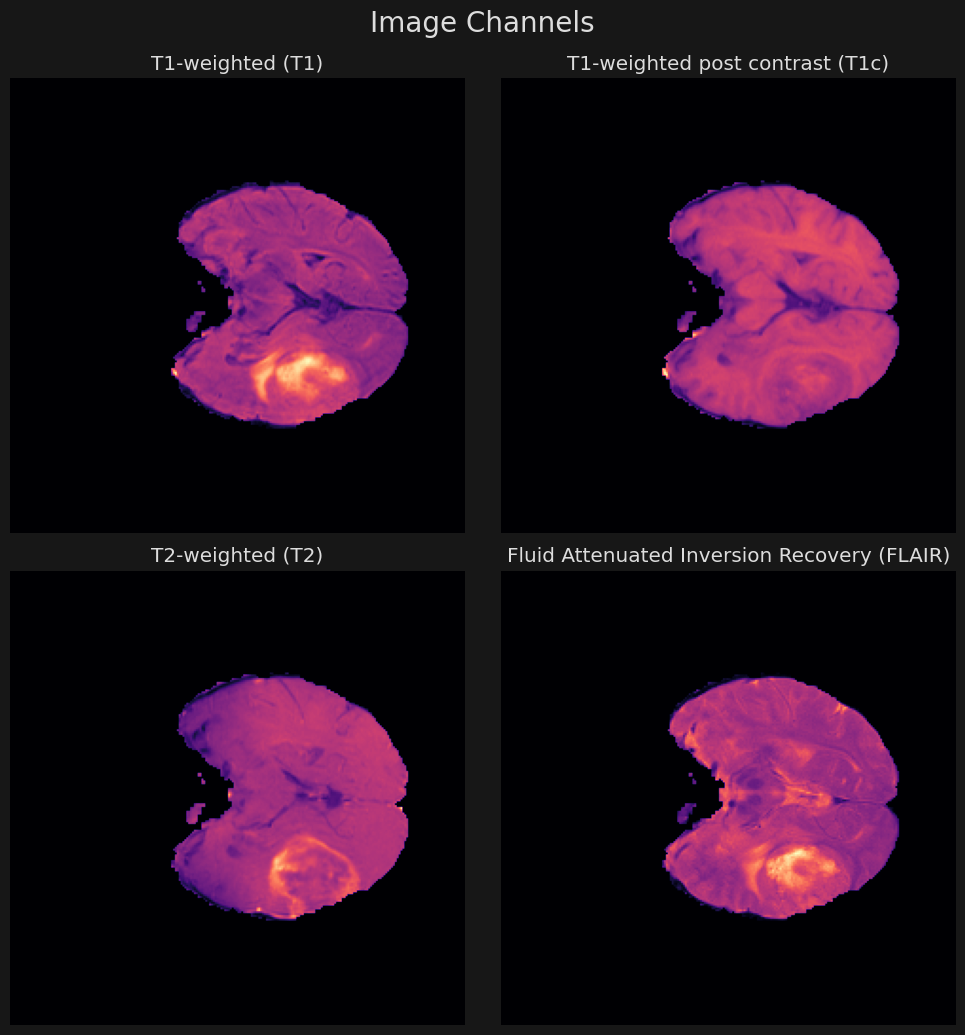

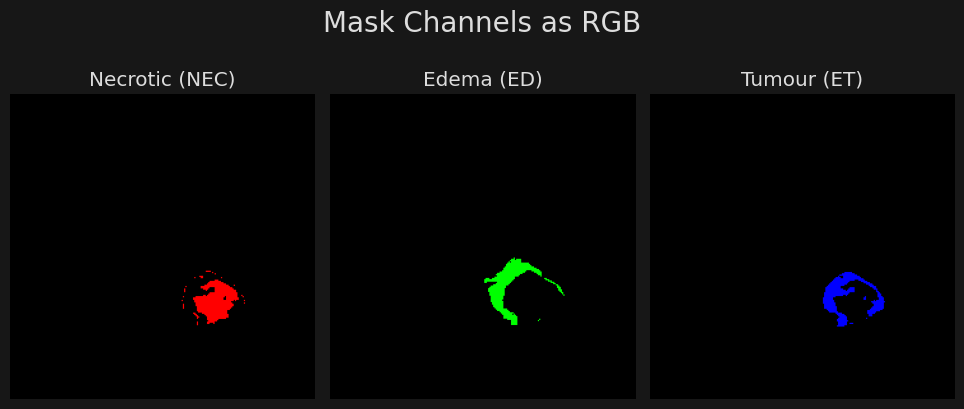

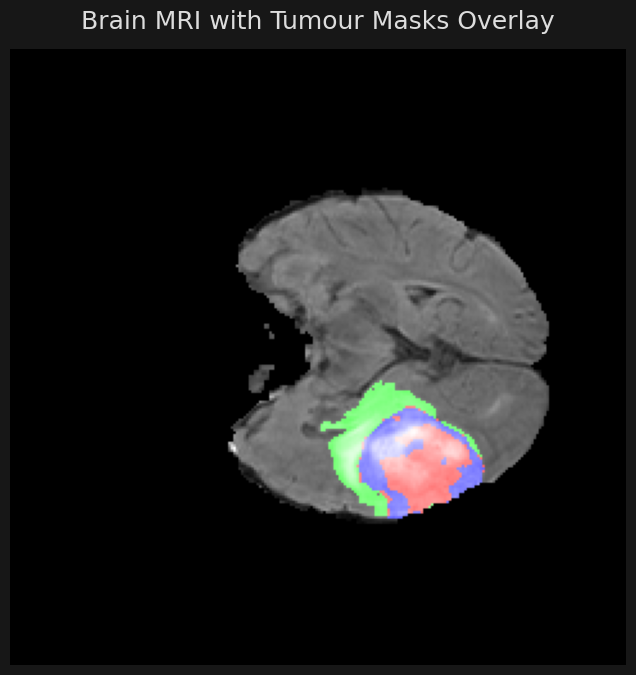

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(dir, h5[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [ ]:
# Attention UNet 
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
        
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
            
            nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
        
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),
            
            nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)
    
class AttentionResBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)
        
        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation
    
    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)
        
        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores
        

class AttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )
        
        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)
        
        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)
        
        # Attention res blocks
        self.att_res_block_1 = AttentionResBlock(1*n_filters)
        self.att_res_block_2 = AttentionResBlock(2*n_filters)
        self.att_res_block_3 = AttentionResBlock(4*n_filters)
        self.att_res_block_4 = AttentionResBlock(8*n_filters)

    def forward(self, x):
        # Encoder
        enc_1 = self.enc_block_1(x)
        x     = self.downsample(enc_1)
        enc_2 = self.enc_block_2(x)
        x     = self.downsample(enc_2)
        enc_3 = self.enc_block_3(x)
        x     = self.downsample(enc_3)
        enc_4 = self.enc_block_4(x)
        x     = self.downsample(enc_4)
        
        # Bottleneck
        dec_4 = self.bottleneck(x)
        
        # Decoder
        x     = self.upsample(dec_4)
        att_4 = self.att_res_block_4(dec_4, enc_4, enc_4)  # QKV
        x     = torch.add(x, att_4)  # Add attention masked value rather than concat
        
        dec_3 = self.dec_block_4(x)
        x     = self.upsample(dec_3)
        att_3 = self.att_res_block_3(dec_3, enc_3, enc_3)
        x     = torch.add(x, att_3)  # Add attention
        
        dec_2 = self.dec_block_3(x)
        x     = self.upsample(dec_2)
        att_2 = self.att_res_block_2(dec_2, enc_2, enc_2)
        x     = torch.add(x, att_2)  # Add attention
        
        dec_1 = self.dec_block_2(x)
        x     = self.upsample(dec_1)
        att_1 = self.att_res_block_1(dec_1, enc_1, enc_1)
        x     = torch.add(x, att_1)  # Add attention
        
        x     = self.dec_block_1(x)
        x     = self.output(x)
        return x

In [4]:
# Define ResUnet++ architecture
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2
        
class ResUnetPlusPlus(nn.Module):
    def __init__(self, filters=[32, 64, 128, 256, 512]):
        super(ResUnetPlusPlus, self).__init__()

        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        self.output_layer = nn.Conv2d(filters[0], out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out

In [ ]:
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='Attention_Unet_brain_segmentation.pth'):
    torch.save(model.state_dict(), path)

def train_model(model, train_dataloader, val_dataloader, config):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()
                
                if val_batch_idx >= batches_per_epoch:
                    break
        val_epoch_losses.append(val_epoch_loss)

        print(f"\nEpoch: {epoch}, Train loss: {train_epoch_loss/len(train_dataloader):.6f}, Val loss: {val_epoch_loss/len(val_dataloader):.6f}, lr {current_lr:.6f}\n")
        
    save_model(model)
    print("Training complete and Model Saved")
    return train_epoch_losses, val_epoch_losses

# Delete old model and clear GPU cache to release memory
# del model
torch.cuda.empty_cache()

# Settings for training
train_config = {
    'device':  'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          30,
    'batch_size':        16,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = AttentionUNet()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config)

In [ ]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(1, 20)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

In [ ]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = AttentionUNet().to(device)
model_test.load_state_dict(torch.load('Attention_Unet_brain_segmentation.pth'))
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model_test, test_input, test_target, device)

In [5]:
from scipy.spatial.distance import directed_hausdorff

# Define evaluation metrics
def dice_coefficient(predicted, target, epsilon=1e-6):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.item()

def intersection_over_union(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    iou = intersection / (union + 1e-6)
    return iou.item()

def sensitivity_specificity(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted * (1 - target))
    false_negative = torch.sum((1 - predicted) * target)
    true_negative = torch.sum((1 - predicted) * (1 - target))
    
    sensitivity = true_positive / (true_positive + false_negative + 1e-6)
    specificity = true_negative / (true_negative + false_positive + 1e-6)
    
    return sensitivity.item(), specificity.item()

def hausdorff_distance(predicted, target):
    predicted_np = predicted.cpu().detach().numpy()
    target_np = target.cpu().detach().numpy()
    
    predicted_points = np.array(np.where(predicted_np == 1)).T
    target_points = np.array(np.where(target_np == 1)).T
    
    hausdorff_dist = max(directed_hausdorff(predicted_points, target_points)[0], directed_hausdorff(target_points, predicted_points)[0])
    
    return hausdorff_dist

# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='Resunet++_brain_segmentation.pth'):
    torch.save(model.state_dict(), path)

def train_model(model, train_dataloader, val_dataloader, config):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    train_dice_scores = []
    train_iou_scores = []
    train_sensitivity_scores = []
    train_specificity_scores = []
    train_hausdorff_distances = []
    val_dice_scores = []
    val_iou_scores = []
    val_sensitivity_scores = []
    val_specificity_scores = []
    val_hausdorff_distances = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        train_dice = 0
        train_iou = 0
        train_sensitivity = 0
        train_specificity = 0
        train_hausdorff = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            # Compute training metrics
            predicted = (torch.sigmoid(train_preds) > 0.5).float()
            train_dice += dice_coefficient(predicted, train_targets)
            train_iou += intersection_over_union(predicted, train_targets)
            sensitivity, specificity = sensitivity_specificity(predicted, train_targets)
            train_sensitivity += sensitivity
            train_specificity += specificity
            train_hausdorff += hausdorff_distance(predicted, train_targets)

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                break
        train_epoch_losses.append(train_epoch_loss/batches_per_epoch)
        train_dice_scores.append(train_dice/len(train_dataloader))
        train_iou_scores.append(train_iou/len(train_dataloader))
        train_sensitivity_scores.append(train_sensitivity/len(train_dataloader))
        train_specificity_scores.append(train_specificity/len(train_dataloader))
        train_hausdorff_distances.append(train_hausdorff/len(train_dataloader))

        # Val step
        model.eval()
        val_epoch_loss = 0
        val_dice = 0
        val_iou = 0
        val_sensitivity = 0
        val_specificity = 0
        val_hausdorff = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

                # Compute validation metrics
                predicted = (torch.sigmoid(val_preds) > 0.5).float()
                val_dice += dice_coefficient(predicted, val_targets)
                val_iou += intersection_over_union(predicted, val_targets)
                sensitivity, specificity = sensitivity_specificity(predicted, val_targets)
                val_sensitivity += sensitivity
                val_specificity += specificity
                val_hausdorff += hausdorff_distance(predicted, val_targets)

                if val_batch_idx >= batches_per_epoch:
                    break
        val_epoch_losses.append(val_epoch_loss/batches_per_epoch)
        val_dice_scores.append(val_dice/len(val_dataloader))
        val_iou_scores.append(val_iou/len(val_dataloader))
        val_sensitivity_scores.append(val_sensitivity/len(val_dataloader))
        val_specificity_scores.append(val_specificity/len(val_dataloader))
        val_hausdorff_distances.append(val_hausdorff/len(val_dataloader))

        print(f"\nEpoch: {epoch}, Train loss: {train_epoch_loss/batches_per_epoch:.6f}, Val loss: {val_epoch_loss/batches_per_epoch:.6f}, lr {current_lr:.6f}\n")
        
    save_model(model)
    print("Training complete and Model Saved")
    return train_epoch_losses, val_epoch_losses, train_dice_scores, train_iou_scores, train_sensitivity_scores, train_specificity_scores, train_hausdorff_distances, val_dice_scores, val_iou_scores, val_sensitivity_scores, val_specificity_scores, val_hausdorff_distances

# Delete old model and clear GPU cache to release memory
# del model
torch.cuda.empty_cache()

# Settings for training
train_config = {
    'device':  'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          30,
    'batch_size':        16,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = ResUnetPlusPlus()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses, train_dice_scores, train_iou_scores, train_sensitivity_scores, train_specificity_scores, train_hausdorff_distances, val_dice_scores, val_iou_scores, val_sensitivity_scores, val_specificity_scores, val_hausdorff_distances = train_model(model, train_dataloader, val_dataloader, train_config)

Total Parameters: 14,483,206

Training...
Val batch: 50/50, Avg batch loss: 0.26689369
Epoch: 1, Train loss: 0.496968, Val loss: 0.272205, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.03441313
Epoch: 2, Train loss: 0.092601, Val loss: 0.034909, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.02917223
Epoch: 3, Train loss: 0.022318, Val loss: 0.029550, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.14951914
Epoch: 4, Train loss: 0.020203, Val loss: 0.150938, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.01800946
Epoch: 5, Train loss: 0.020935, Val loss: 0.018341, lr 0.001000

Val batch: 50/50, Avg batch loss: 1.12060706
Epoch: 6, Train loss: 0.020338, Val loss: 1.120942, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.79721129
Epoch: 7, Train loss: 0.017629, Val loss: 0.797519, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.01738601
Epoch: 8, Train loss: 0.016748, Val loss: 0.017698, lr 0.001000

Val batch: 50/50, Avg batch loss: 0.01779086
Epoch: 9, Train loss: 0.016705, V

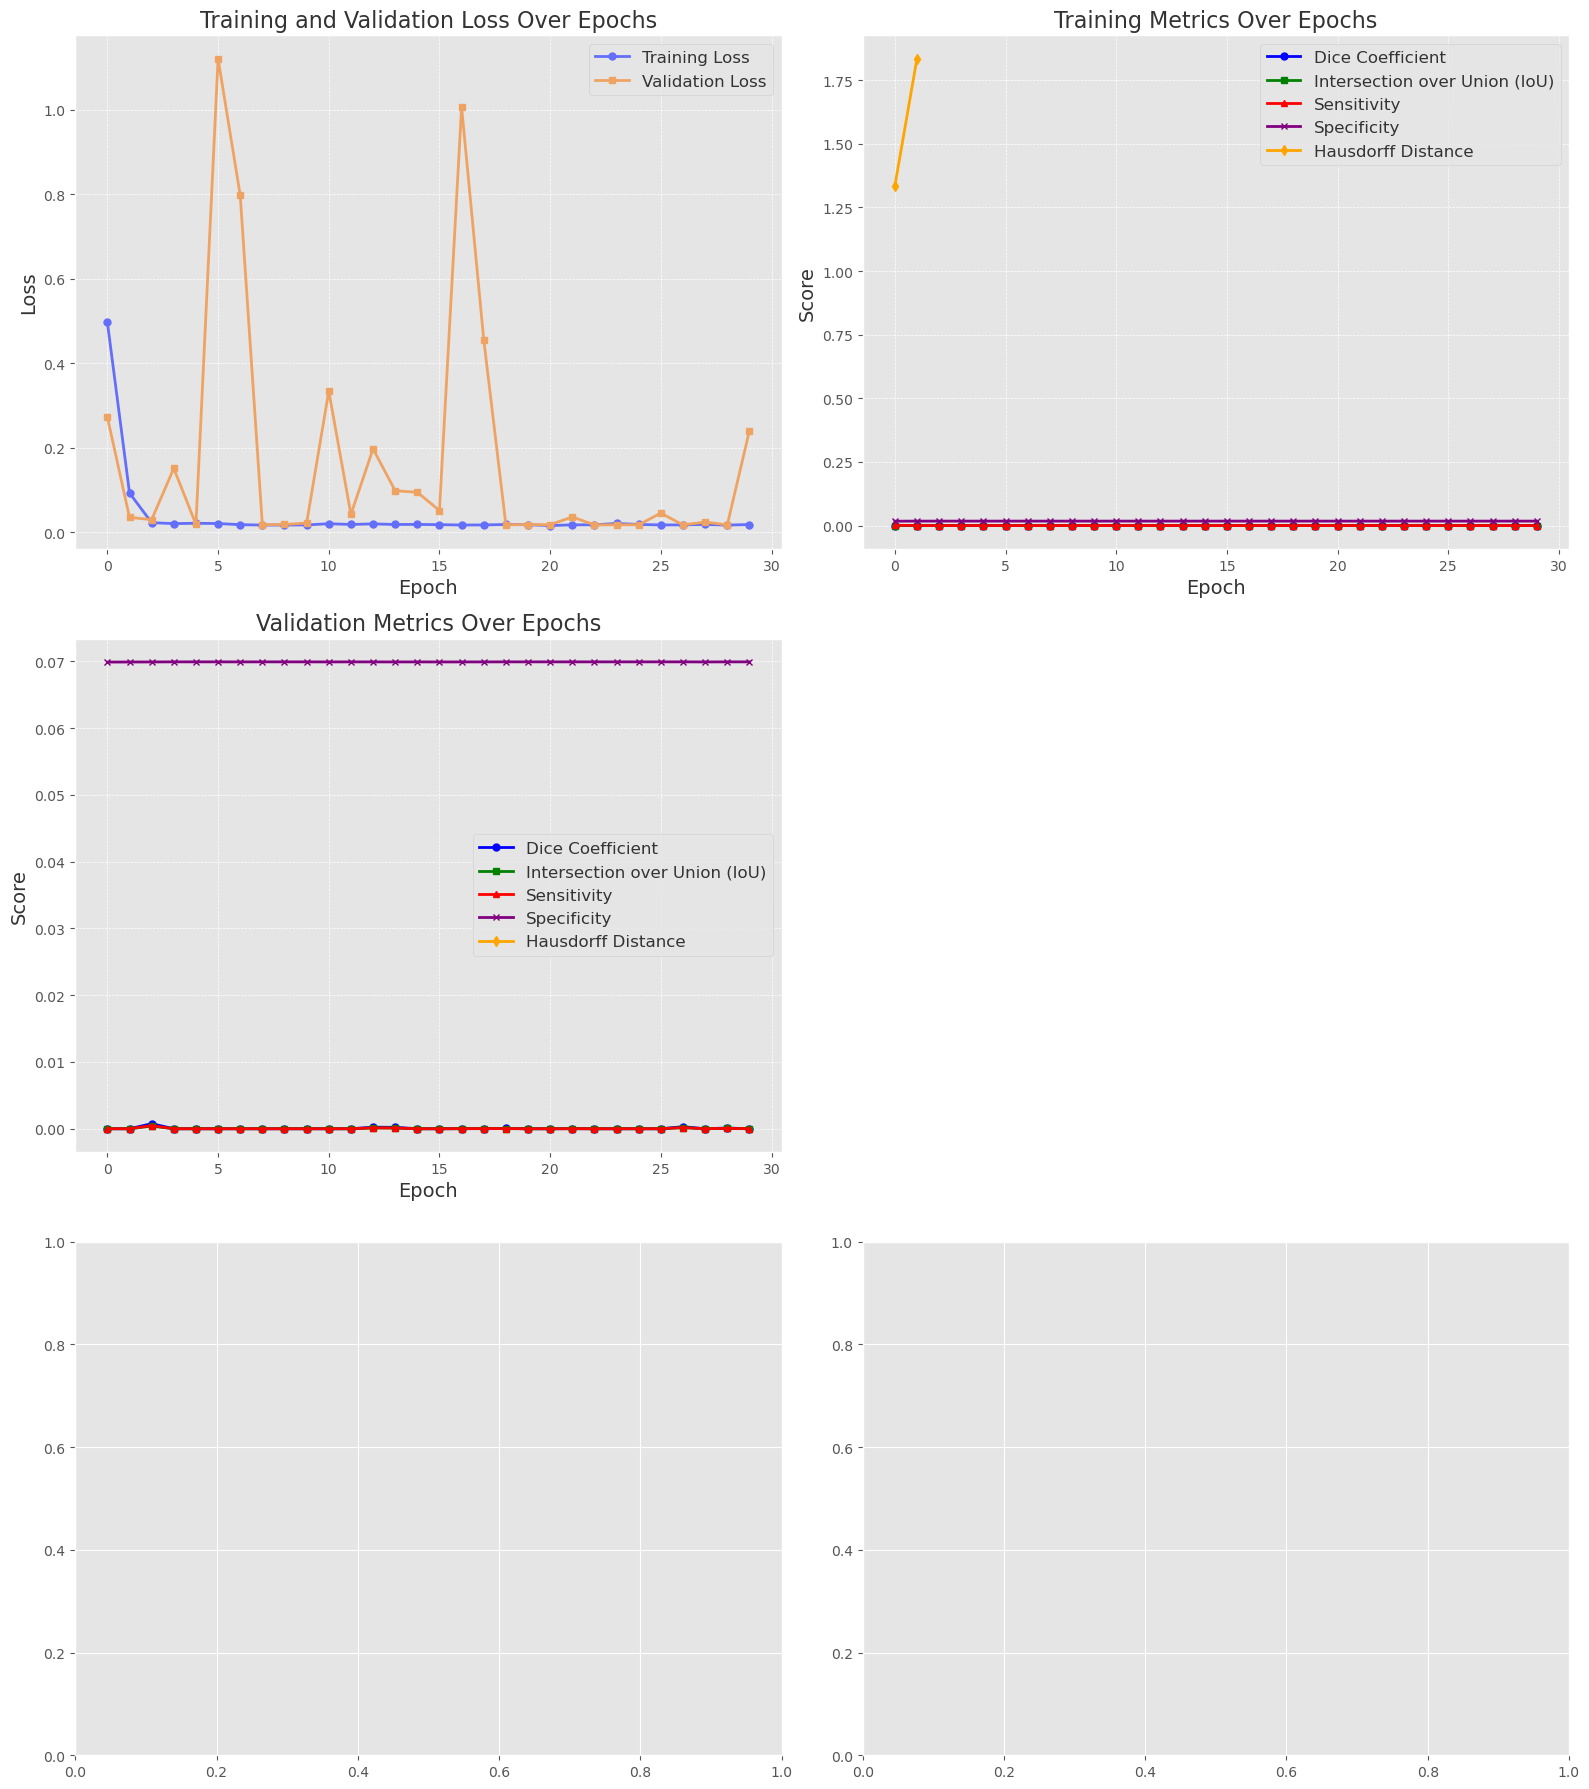

In [6]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses, train_dice_scores, train_iou_scores, train_sensitivity_scores, train_specificity_scores, train_hausdorff_distances, val_dice_scores, val_iou_scores, val_sensitivity_scores, val_specificity_scores, val_hausdorff_distances):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # Plot training and validation loss
    axes[0, 0].plot(train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axes[0, 0].plot(val_epoch_losses, color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')
    axes[0, 0].set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axes[0, 0].set_xlabel('Epoch', fontsize=14)
    axes[0, 0].set_ylabel('Loss', fontsize=14)
    axes[0, 0].legend(fontsize=12)
    axes[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot training metrics
    axes[0, 1].plot(train_dice_scores, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Dice Coefficient')
    axes[0, 1].plot(train_iou_scores, color='green', marker='s', linestyle='-', linewidth=2, markersize=5, label='Intersection over Union (IoU)')
    axes[0, 1].plot(train_sensitivity_scores, color='red', marker='^', linestyle='-', linewidth=2, markersize=5, label='Sensitivity')
    axes[0, 1].plot(train_specificity_scores, color='purple', marker='x', linestyle='-', linewidth=2, markersize=5, label='Specificity')
    axes[0, 1].plot(train_hausdorff_distances, color='orange', marker='d', linestyle='-', linewidth=2, markersize=5, label='Hausdorff Distance')
    axes[0, 1].set_title('Training Metrics Over Epochs', fontsize=16)
    axes[0, 1].set_xlabel('Epoch', fontsize=14)
    axes[0, 1].set_ylabel('Score', fontsize=14)
    axes[0, 1].legend(fontsize=12)
    axes[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot validation metrics
    axes[1, 0].plot(val_dice_scores, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Dice Coefficient')
    axes[1, 0].plot(val_iou_scores, color='green', marker='s', linestyle='-', linewidth=2, markersize=5, label='Intersection over Union (IoU)')
    axes[1, 0].plot(val_sensitivity_scores, color='red', marker='^', linestyle='-', linewidth=2, markersize=5, label='Sensitivity')
    axes[1, 0].plot(val_specificity_scores, color='purple', marker='x', linestyle='-', linewidth=2, markersize=5, label='Specificity')
    axes[1, 0].plot(val_hausdorff_distances, color='orange', marker='d', linestyle='-', linewidth=2, markersize=5, label='Hausdorff Distance')
    axes[1, 0].set_title('Validation Metrics Over Epochs', fontsize=16)
    axes[1, 0].set_xlabel('Epoch', fontsize=14)
    axes[1, 0].set_ylabel('Score', fontsize=14)
    axes[1, 0].legend(fontsize=12)
    axes[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Remove empty subplot
    fig.delaxes(axes[1, 1])
    plt.tight_layout()
    plt.show()

plot_learning_curves(train_epoch_losses, val_epoch_losses, train_dice_scores, train_iou_scores, train_sensitivity_scores, train_specificity_scores, train_hausdorff_distances, val_dice_scores, val_iou_scores, val_sensitivity_scores, val_specificity_scores, val_hausdorff_distances)


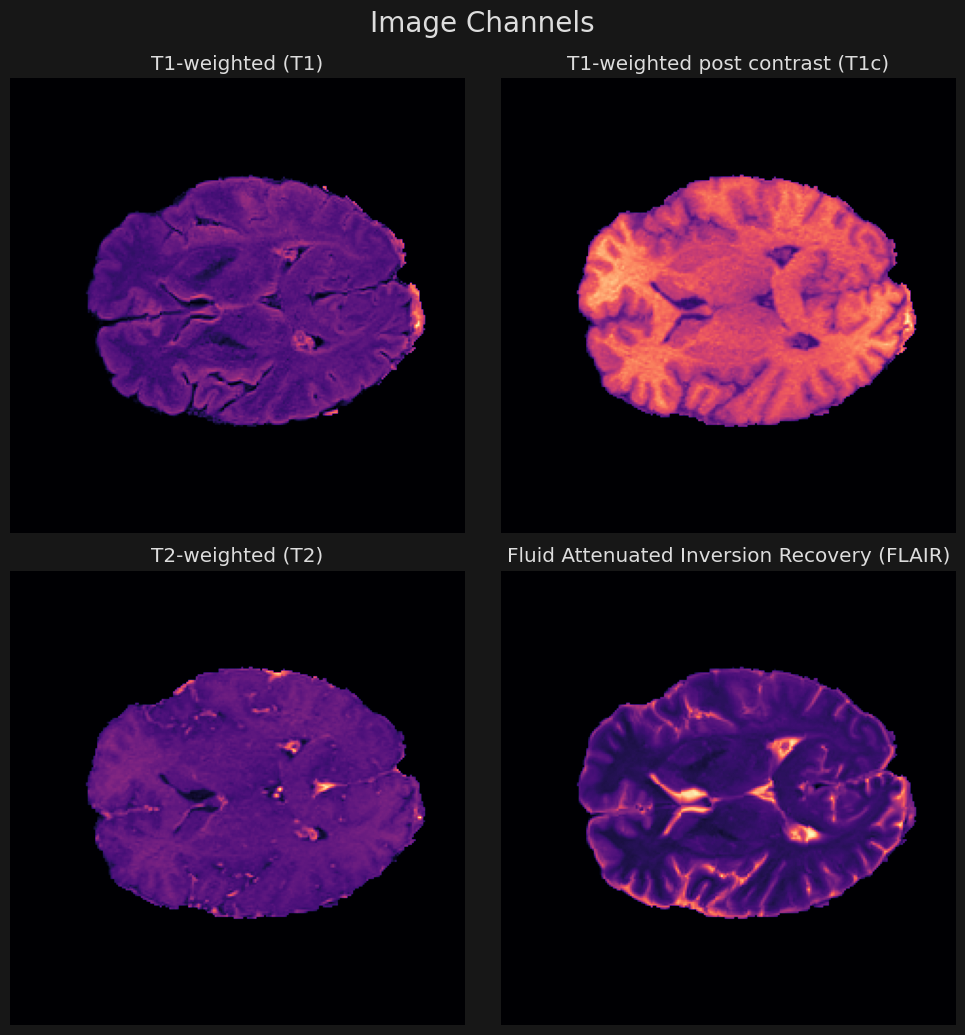

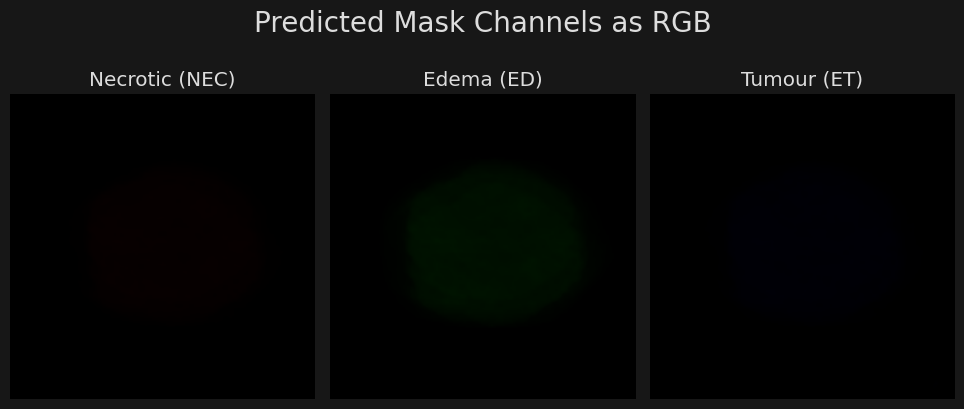

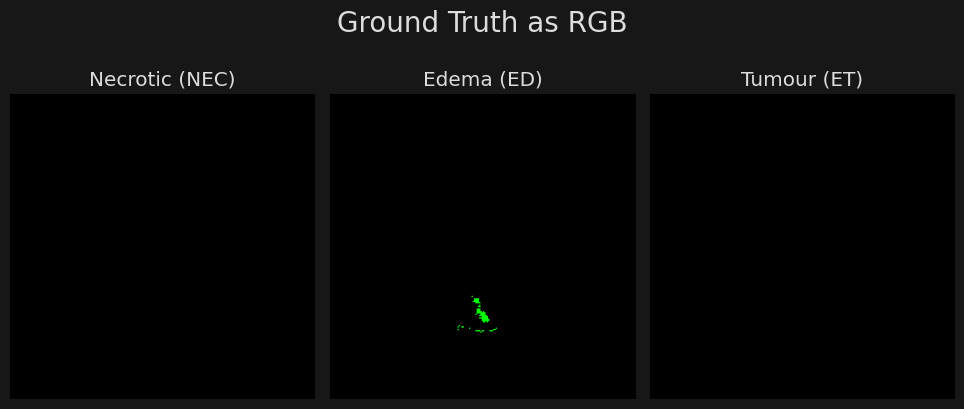

In [10]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = ResUnetPlusPlus().to(device)
model_test.load_state_dict(torch.load('Resunet++_brain_segmentation.pth'))
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model_test, test_input, test_target, device)